In [41]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
# df=pd.read_csv("/content/drive/MyDrive/UNSW_NB15/UNSW_NB15_training-set.csv")
df=pd.concat([pd.read_csv('/content/drive/MyDrive/UNSW_NB15/UNSW-NB15_1.csv', header=None), \
    pd.read_csv('/content/drive/MyDrive/UNSW_NB15/UNSW-NB15_2.csv', header=None), \
        pd.read_csv('/content/drive/MyDrive/UNSW_NB15/UNSW-NB15_3.csv', header=None), \
            pd.read_csv('/content/drive/MyDrive/UNSW_NB15/UNSW-NB15_4.csv', header=None)], ignore_index=True)
# df['attack_cat']

<ipython-input-72-398a89f3de59>:2: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.concat([pd.read_csv('/content/drive/MyDrive/UNSW_NB15/UNSW-NB15_1.csv', header=None), \
<ipython-input-72-398a89f3de59>:3: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('/content/drive/MyDrive/UNSW_NB15/UNSW-NB15_2.csv', header=None), \


In [43]:
!pip install tensorflow

In [44]:
!pip install np_utils
import np_utils

In [73]:
from pandas.core.frame import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
# from tensorflow.keras.utils import np_utils
from keras.utils import to_categorical
import pandas as pd

def data_spli_to_fit(data):
    data = data.drop([0],axis=1)
    data = data.drop([1],axis=1)
    data = data.drop([2],axis=1)
    data = data.drop([3],axis=1)
    data[47] = data[47].fillna('Normal')
    data[47] = data[47].replace(' Fuzzers','Fuzzers')
    data[47] = data[47].replace(' Fuzzers ','Fuzzers')
    data[47] = data[47].replace(' Reconnaissance','Reconnaissance')
    data[47] = data[47].replace(' Reconnaissance ','Reconnaissance')
    data[47] = data[47].replace(' Shellcode','Shellcode')
    data[47] = data[47].replace(' Shellcode ','Shellcode')
    data[47] = data[47].replace('Backdoors','Backdoor')
    data = data.fillna(0)
    data[39] = data[39].replace(' ',0)
    data[39] = data[39].astype('int64')
    data_2_type = data[4].unique().tolist()
    data_3_type = data[5].unique().tolist()
    data_4_type = data[13].unique().tolist()
    data = data.drop([48], axis=1) #删除Label
    data[4]= data[4].apply(lambda x : data_2_type.index(x))
    data[5] = data[5].apply(lambda x : data_3_type.index(x))
    data[13] = data[13].apply(lambda x : data_4_type.index(x))
    unlabled_data = data.drop([47],axis=1)
    return(unlabled_data, pd.DataFrame(data[47]))

def data_select(data, nums=100):
    data_43_type = data[47].unique().tolist()
    print(data_43_type)
    print(data[47].value_counts())
    data[47] = data[47].apply(lambda x : data_43_type.index(x))
    r_data = DataFrame()

    for x in range(10):
        tp = data[data[47] == x]
        tp = shuffle(tp)
        tp = tp.iloc[1:nums+1]
        r_data = pd.concat([r_data, tp], ignore_index=True)
    data = shuffle(r_data)
    unlabeled_data  = data.drop([47],axis=1)
    res = np_utils.to_categorical(data[47], num_classes=10)
    return (unlabeled_data, res, data_43_type)

def data_s(data, sp_num):
    data_43_type = data[47].unique().tolist()
    print(data_43_type)
    print(data[47].value_counts())
    data[47] = data[47].apply(lambda x : data_43_type.index(x))
    train_data = DataFrame()
    test_data = DataFrame()
    for x in range(0,len(sp_num)):
        tp = data[data[47] == x]
        train_data = pd.concat([train_data, tp.iloc[1:sp_num[x]+1]], ignore_index=True)
        test_data = pd.concat([test_data, tp.iloc[sp_num[x]+1:-1]], ignore_index=True)
    train_data = shuffle(train_data)
    test_data = shuffle(test_data)
    ub_train = train_data.drop([47],axis=1)
    ub_test = test_data.drop([47],axis=1)
    train_res = to_categorical(train_data[47], num_classes=10)
    test_res = to_categorical(test_data[47], num_classes=10)
    return(train_data, train_res, test_data, test_res, data_43_type)

In [74]:
(df,res) =  data_spli_to_fit(df)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df)
data = pd.DataFrame(scaler.transform(df))
data = pd.concat([data, res],axis=1)
#data.info()
sp_num = [1370880,23275,7608,8281,131435,811,13712,87,1371,1440]
(train_data, train_res, test_data, test_res, data_43_type) = data_s(data,sp_num)
#p.info()

['Normal', 'Exploits', 'Reconnaissance', 'DoS', 'Generic', 'Shellcode', 'Fuzzers', 'Worms', 'Backdoor', 'Analysis']
Normal            2218764
Generic            215481
Exploits            44525
Fuzzers             24246
DoS                 16353
Reconnaissance      13987
Analysis             2677
Backdoor             2329
Shellcode            1511
Worms                 174
Name: 47, dtype: int64


In [76]:
train_data[47].value_counts()

0    1370880
4     131435
1      23275
6      13712
3       8281
2       7608
9       1440
8       1371
5        811
7         87
Name: 47, dtype: int64

In [78]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten , Activation, SimpleRNN, LSTM, GRU, Dropout, TimeDistributed, Reshape, Input, Lambda, Add
from tensorflow.keras import Sequential
model = Sequential()
model.add(Reshape((-1,1), input_shape=(44,)))
model.add(Conv1D(32, 3, activation='relu', padding='causal'))
model.add(Conv1D(64, 3, activation='relu', padding='causal'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(70,recurrent_dropout=0.1))
model.add(Flatten())
model.add(Dense(10,activation='softmax'))
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.005), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_data, train_res, epochs=5, batch_size=2048)

Epoch 1/5
762/762 [==============================] - 462s 600ms/step - loss: 0.0319 - accuracy: 0.9628
Epoch 2/5
762/762 [==============================] - 461s 605ms/step - loss: 0.0052 - accuracy: 0.9932
Epoch 3/5
762/762 [==============================] - 456s 598ms/step - loss: 0.0036 - accuracy: 0.9960
Epoch 4/5
762/762 [==============================] - 457s 600ms/step - loss: 0.0028 - accuracy: 0.9968
Epoch 5/5
762/762 [==============================] - 457s 600ms/step - loss: 0.0023 - accuracy: 0.9972


480/480 [==============================] - 75s 155ms/step


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


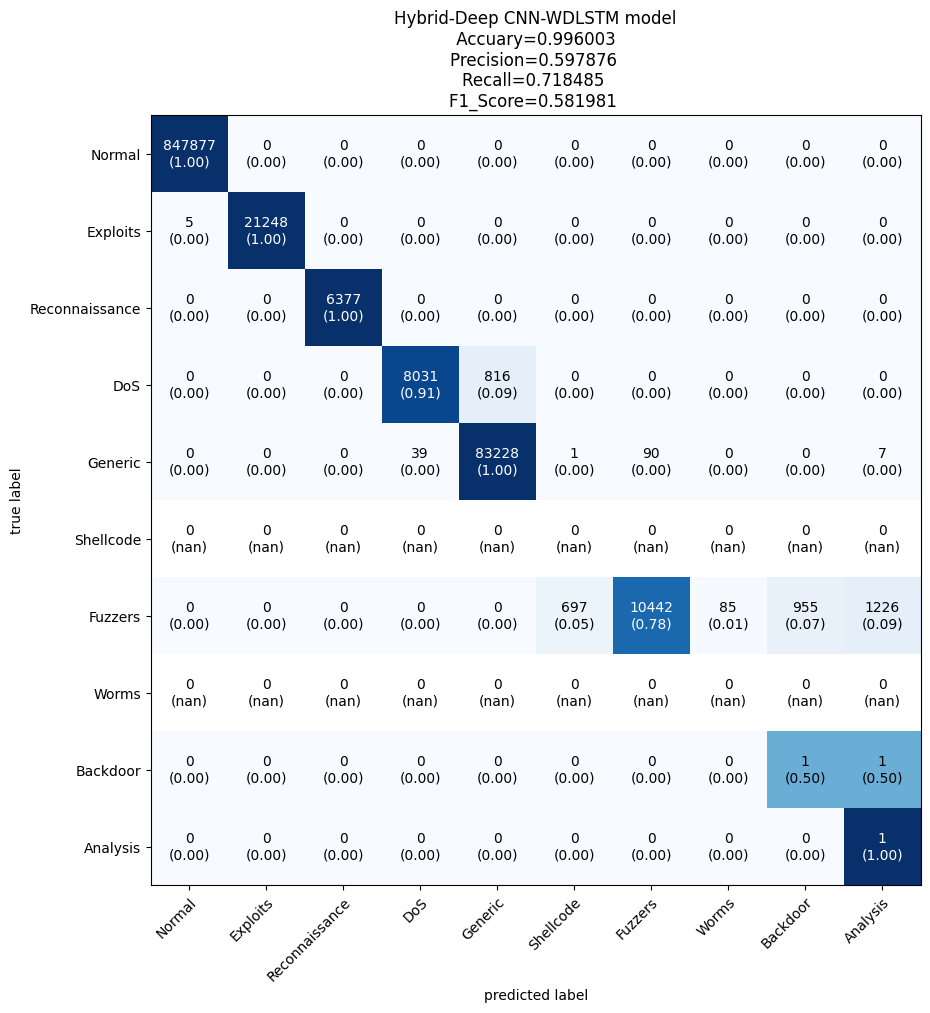

In [79]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

res = model.predict(test_data, batch_size=2048)
def confusion_plot(roi,res,title=None, class_name=None):
    fig, ax = plot_confusion_matrix(conf_mat = confusion_matrix(roi,res), class_names = class_name, show_absolute=True, show_normed=True, hide_spines=False, hide_ticks=False, figsize=(10,10))
    plt.title(title+'\n Accuary=%f \nPrecision=%f \nRecall=%f \nF1_Score=%f '%(\
    accuracy_score(roi,res),\
    precision_score(roi,res, average='macro'),\
    recall_score(roi,res, average='macro'),\
    f1_score(roi,res, average='macro')\
))
    plt.show()
confusion_plot(res.argmax(axis=-1), test_res.argmax(axis=-1), 'Hybrid-Deep CNN-WDLSTM model', data_43_type)

In [ ]:
import matplotlib.pyplot as plt

# Create some sample data
epochs = range(1, 101)
training_accuracy = model.evaluate(train_data, train_res)
testing_accuracy = model.evaluate(test_data, test_res)

print(training_accuracy)
print(testing_accuracy)
# Create the line plot
# plt.plot(epochs, training_accuracy, label='Training Accuracy')
# plt.plot(epochs, testing_accuracy, label='Testing Accuracy')

# # Add labels and a title
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Model Accuracy')

# # Add a legend
# plt.legend()

# # Show the plot
# plt.show()


 412/2028 [=====>........................] - ETA: 12s - loss: 0.0071 - accuracy: 0.9960

KeyboardInterrupt: 